# <center>Signal-Based Trading Strategy Using Granger Causality Test and Moving Average

### <center> Yuqian Li

# 1. Strategy

## 1.1 Data

10 large-cap tickers + 10 small-cap tickers; 2021 - 2024(today) stock data from yahoo finance library

## 1.2 30-day Rolling Yang-Zhang Volatility

Calculate 30-day Rolling Yang-Zhang volatility for each ticker

## 1.3 Discover co-change pattern by Granger Causality Test (GCT)

For large-cap list, group tickers into `(X, Y)` pair, where `X` has relatively large cap in the list and `Y` has relatively small cap. 

Conduct Granger Causality Test:

$H_0$: X's price does not have an impact on Y's price with a lag of `lag`

If $p_{value} < \alpha$ (significance level), reject $H_0$, i.e. conclude that X's price has an impact on Y's price with a lag of `lag`

For each pair, and for each `lag`, the result $p_{value}$ is different. Filter out those whose $p_{value} < \alpha$ (significance level).

On this basis, for each pair, choose the `lag*` with lowest $p_{value}$, which shows a stronger evidence that `X` has a significant impact on `Y`'s price with a lag of `lag*`

Finally, for large-cap list, we have a list of pairs `[{'X':..., 'Y':..., 'lag':..., 'p_value':...}]`. We use this to design strategy - __detect signal from X and accordingly make trades on Y.__

## 1.4 Design signal mechanism based on Moving Average (MA) of `X`, for trade of `Y`

1. __Moving Average:__

By definition,

$$MA(P_t, window) = \frac{1}{window} \sum_{i = t-window}^{t-1} P_i $$

For `X`, 
 - if $P_t < k_1 * MA(P_t, window)$, where $k_1 > 1.0$, it generates a signal to buy `Y` at $t + lag*$ 
 - if $P_t > k_2 * MA(P_t, window)$, where $k_2 < 1.0$, it generates a signal to sell `Y` at $t + lag*$ 


2. __Criteria for buying and selling `Y`:__

At $t$, 
 - **Buy**: If there is a buy signal AND `position` = 0 (means no unclosed position now), then we buy `Y` with `cash` at the price of $P_t$, therefore holding `position` shares of `cash`/$P_t$
 - - Unless $t + lag*$ >= T (period end), because
 - - - If $t + lag*$ = T, it means we even need to open position at end, then due to 'T+1' regulation, we can't close position by end.
 - - - If $t + lag*$ > T, it means we even don't have time to open position by end.
 - **Sell**: If there is a sell signal AND `position` > 0 (means unclosed position now), then we sell `position` shares`Y` at the price of $P_t$, therefore receiving `cash`  = `position` * $P_t$ 
 - **Maintain the Status Quo**: Under other cirsumstances, hold current `position` and no other move
 - **Final force liquidation if still holding**: At $P_T$, if `position` > 0, conduct final sell.
 
 
## 1.5 Performance evaluation metrics

Conduct the trading of `Y` based on 1.4 thoughout the entire period, there are several holding periods (number = $m$) within. Record the daily return $R_t = \bigcup_{i=1}^{m} R_{t_{i}}$ in every holding period, for calculating sharpe ratio and max drawdown.

 - __Total return__: final `cash` / `initial_capital` - 1

 - __Benchmark 1__: Buy-and-hold: $P_T$ / $P_0$ - 1

 - __Benchmark 2__: Secured Overnight Financing Rate (SOFR) at $T$ (annualized)

 - __Sharpe Ratio__: $$SR = \frac{mean(R_t)_{ann} - SOFR}{std(R_t)_{ann}}$$

 - __Max Drawdown__: $$MDD = \min_{1 \le i \le m} {\min_t (\frac{P_{t_{i}}}{cummax(P_{t_{i}})} - 1 )}$$

Note, the cummax does not include that day $t$, but includes every day before in the holding period.

 - **Alpha**: The strategy's excess return over a benchmark after adjusting for market-related volatility and random fluctuations, representing the value added by the strategy's unique approach.

 - **Beta-Neutral**: A beta-neutral strategy seeks to have a beta (the strategy's snsitiviy to market movements) close to zero, indicating that its performance is independent of market swings and ideal for minimizing systemic risk.

## 1.6 Train and Test (backtesting)

Set up 3 training sets: 2021-2022, 2022-2023, 2023-2024
Set up 1 test (backtesting) set: 2024-today

__Grid_search__ for parameters `window` of MA, `k1`, `k2`:
 - `window` in range(1, 11)
 - `k1` in np.linspace(1.0, 1.5, 11)
 - `k2` in np.linspace(0.5, 1.0, 11):

Set the mean sharpe ratio of model on 3 training sets as the criterion for best model.

For each (`X`,`Y`) pair, find the best model with best parameters. Apply this model on the test set, and use metrics on test set as the metrics for strategy on this pair.

We give the same `initial_capital` to each pair. Since the holding periods in each pair is different, we cannot use the portfolio sharpe ratio to evaluate the entire trading strategy. Rather, we use the mean of all the sharpe ratio (for each pair in this strategy).

## 1.7 Conduct the analysis above for large-cap group / small-cap group $\times$ with / without transaction cost

With transaction cost, we need to apply a deduction of cash when opening and closing positions: `cash` = `cash` * (1 - `transaction`), where `transaction` means the rate.

# 2. Reference

## 2.1 Reference

We referred to these papers and applied the Rolling Yang-Zhang Volatility, Granger Causality Test, and Moving Average thoughts in our paper.

- Letteri, I. (2023). **VolTS: A Volatility-based Trading System to forecast Stock Markets Trend using Statistics and Machine Learning**. University of L’Aquila, Coppito, snc, 67100 L’Aquila, Italy. Retrieved from [http://www.ivanletteri.it](http://www.ivanletteri.it)

- Yang, D., & Zhang, Q. (2000). **Drift-Independent Volatility Estimation Based on High, Low, Open, and Close Prices**. *The Journal of Business*, 73(3), 477–492. Published by The University of Chicago Press. [https://www.jstor.org/stable/10.1086/209650](https://www.jstor.org/stable/10.1086/209650)

- Kirchgässner, G., & Wolters, J. (2007). **Granger Causality**. In *Introduction to Modern Time Series Analysis* (pp. 93–123). Springer Berlin Heidelberg, Berlin, Heidelberg. [https://doi.org/10.1007/978-3-540-73291-4_3](https://doi.org/10.1007/978-3-540-73291-4_3)

- Secured Overnight Financing Rate (SOFR). https://www.newyorkfed.org/markets/reference-rates/sofr

## 2.2 Contrast
### 2.2.1. Scope of Stock Selection

- **VolTS Article**: The article focuses exclusively on **9 large-cap stocks**, potentially limiting the generalizability of their findings to the overall market, especially small-cap or less liquid stocks.

- **Our Strategy**: We consider both **10 large-cap stocks** and **10 small-cap stocks**, ensuring representation across different market capitalizations. This broader scope enables our model to capture trends and behaviors in both large and small market participants.

### 2.2.2. Discussion of Transaction Cost

- **VolTS Article**: no transaction cost

- **Our Strategy**: with / without transaction cost

### 2.2.3. Training and Testing Mindset

- **VolTS Article**: no training / testing, only one set. Therefore, it can intentionally choose the params / data period to make results really good.

- **Our Strategy**: when keeping the testing set as a vault, find the best model by training. Then use the testing set to backtest our strategy, being totally honest.

# 3. Assumptions

- **Infinite Divisibility**: Stocks allow for precise adjustments to portfolio positions.
- **T+1 trading system**: Securities bought today cannot be sold until the next trading day.
- **No Dividend**: Assets pay no dividends or other distributions during the time.
- **Liquidity**: Assets are assumed to exhibit high liquidity, ensuring minimal market impact on entry and exit of positions, and maintaining narrow bid-ask spreads.

These assumptions form the theoretical bedrock for our strategy’s design, implementation, and anticipated performance within the financial market context.

# 4. Code Implementation

## 4.1 Data Preparation

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_market_calendars as mcal

#from tslearn.clustering import TimeSeriesKMeans
from scipy import stats
from tslearn.metrics import dtw
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import grangercausalitytests
#from itertools import permutations

from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [81]:
large_cap_stocks = ["AAPL", "NVDA", "MSFT", "AMZN", "META", "TSLA", "BRK-B", "JPM", "V", "JNJ"]
small_cap_stocks = ["HEI", "FDS", "IEX", "TECH", "TTC", "CHE", "RLI", "MSA", "BCPC","AMED"]

large_cap_data = yf.download(large_cap_stocks, start="2021-01-01", end=pd.to_datetime("today").strftime('%Y-%m-%d'))[['Open', 'High', 'Low', 'Adj Close']]
small_cap_data = yf.download(small_cap_stocks, start="2021-01-01", end=pd.to_datetime("today").strftime('%Y-%m-%d'))[['Open', 'High', 'Low', 'Adj Close']]

# multi-index .loc[:,('open','AAPL')]

print(f"Large Cap Stocks Data contains {len(large_cap_data)} records.")
print(f"Small Cap Stocks Data contains {len(small_cap_data)} records.")

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
Large Cap Stocks Data contains 999 records.
Small Cap Stocks Data contains 999 records.


In [6]:
# risk-free rate (SOFR)
df_rf = pd.read_excel('SOFR.xlsx')
df_rf['Effective Date'] = pd.to_datetime(df_rf['Effective Date'])
df_rf.set_index('Effective Date', inplace=True)

In [8]:
# don't use this finally because of speed
def get_trading_date(cur_date, offset):
    
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date="2021-01-01", end_date=pd.to_datetime("today").strftime('%Y-%m-%d'))
    trading_days = mcal.date_range(schedule, frequency='1D').normalize().tz_localize(None)
    
    if isinstance(cur_date, str): cur_date = pd.to_datetime(cur_date, format='%Y-%m-%d')
    
    current_idx = trading_days.get_loc(cur_date)
    next_date = trading_days[current_idx + offset]

    return next_date

## 4.2 Rolling Yang-Zhang Volatility

### Input Data Structure
The input `df` is a MultiIndex DataFrame with the following structure:
- **First-level columns**: `['Open', 'High', 'Low', 'Adj Close']`
- **Second-level columns**: Stock tickers like `AAPL`, `MSFT`, etc.

---

### Steps in the Function

#### 1. Extract Stock Data
- Each ticker is processed separately to compute its volatility components.

#### 2. Log Returns
Log returns are calculated as follows:
- **Open Jump**: 
  $$
  o_i = \ln(O_i) - \ln(C_{i-1})
  $$
- **Open-to-Close**:
  $$
  c_i = \ln(C_i) - \ln(O_i)
  $$
- **High and Low**:
  $$
  u_i = \ln(H_i) - \ln(O_i), \quad d_i = \ln(L_i) - \ln(O_i)
  $$

#### 3. Components of Variance
- **Vo**: Variance of open jumps over the rolling window:
  $$
  V_O = \frac{1}{n-1} \sum_{i=1}^n (o_i - \bar{o})^2
  $$
- **Vc**: Variance of open-to-close log returns:
  $$
  V_C = \frac{1}{n-1} \sum_{i=1}^n (c_i - \bar{c})^2
  $$
- **Vrs**: Rogers-Satchell variance using high, low, and close prices:
  $$
  V_{RS} = \frac{1}{n} \sum_{i=1}^n \left[u_i(u_i - c_i) + d_i(d_i - c_i)\right]
  $$

#### 4. Weight Factor $k$
The weight factor $k$ is calculated dynamically based on the rolling window size:
$$
k = \frac{\alpha - 1}{\alpha + \frac{n+1}{n-1}}
$$
Where:
- $\alpha$: Fixed parameter (recommended value $\alpha = 1.34$).
- $n$: Rolling window size.

#### 5. Combine Components
The variance $V$ is computed as:
$$
V = V_O + k V_C + (1-k) V_{RS}
$$
The volatility is then obtained by taking the square root:
$$
\text{Volatility} = \sqrt{V}
$$

---

### Rolling Computation
- Use `rolling(window=30)` to compute rolling variance or mean for each component.
- This ensures that the volatility reflects the most recent 30-day period (default window).

---

### Output
The function outputs a DataFrame with:
- **Rows**: Dates.
- **Columns**: Tickers.
- **Values**: Rolling Yang-Zhang volatility for each stock.

In [10]:
def yz_vol(df, window=30): 
    """
    Calculate Yang-Zhang volatility time series.
    
    Parameters:
        df: MultiIndex DataFrame with ['Open', 'High', 'Low', 'Adj Close'] × [tickers]
        window: Rolling window size (default is 30 days)
    
    Returns:
        A DataFrame with Yang-Zhang volatility time series for each stock.
        
    Future work: set window to be how large?
    """
    # Get unique tickers from the second level of column index
    tickers = df.columns.get_level_values(1).unique()
    vol_data = {}

    for ticker in tickers:
        # Extract data for the specific ticker
        open_price = df['Open'][ticker]
        high_price = df['High'][ticker]
        low_price = df['Low'][ticker]
        close_price = df['Adj Close'][ticker]

        # Calculate log returns
        log_open = np.log(open_price)
        log_high = np.log(high_price)
        log_low = np.log(low_price)
        log_close = np.log(close_price)

        # Open jump component (Vo)
        o = log_open - log_close.shift(1)
        Vo = o.rolling(window=window).var()

        # Open-to-close component (Vc)
        c = log_close - log_open
        Vc = c.rolling(window=window).var()

        # Rogers-Satchell component (Vrs)
        u = log_high - log_open  # Log return from open to high
        d = log_low - log_open   # Log return from open to low
        Vrs = (u * (u - c) + d * (d - c)).rolling(window=window).mean()

        # Weight factor k
        alpha = 1.34  # Fixed parameter
        n = window
        k = (alpha - 1) / (alpha + (n + 1) / (n - 1))

        # Yang-Zhang volatility
        yz_vol = (Vo + k * Vc + (1 - k) * Vrs).apply(np.sqrt)
        vol_data[ticker] = yz_vol

    # Convert the results into a DataFrame
    vol_df = pd.DataFrame(vol_data)
    vol_df.index = df.index  # Use the original index from the input data
    
    return vol_df

In [82]:
large_cap_vol = yz_vol(df=large_cap_data, window=30)
small_cap_vol = yz_vol(df=small_cap_data, window=30)

## 4.3 Find co-change pairs by Granger Causality Test (GCT)

## Granger Causality Test (GCT): An Overview

The **Granger Causality Test (GCT)** is a statistical hypothesis test used to determine whether one time series can predict another. It is widely applied in econometrics, neuroscience, and other fields involving time-series analysis. The test is based on the concept of **causality in prediction** rather than true causation in the philosophical sense.

### **Core Principle**
Granger causality revolves around the idea that if a time series $X_t$ Granger-causes $Y_t$, then past values of $X_t$ contain information that helps predict $Y_t$, above and beyond the information contained in past values of $Y_t$ alone.

### **How It Works**
1. **Modeling**: The test uses a vector autoregressive (VAR) model to assess the relationship between two time series. For two time series $X_t$and $Y_t$, two models are estimated:
   - A restricted model: $Y_t$ is regressed only on its own past values.
   - An unrestricted model: $Y_t$ is regressed on both its own past values and the past values of $X_t$.


2. **Hypothesis Testing**:
   - **Null Hypothesis $H_0$**: $X_t$ does not Granger-cause $Y_t$. In other words, the past values of $X_t$ do not significantly improve the prediction of $Y_t$.
   - **Alternative Hypothesis $H_1$**: $X_t$ Granger-causes $Y_t$.


3. **Statistical Significance**:
   - The test uses an F-statistic to compare the two models. If the unrestricted model (with $X_t$) significantly reduces prediction error compared to the restricted model, $H_0$ is rejected.

In [14]:
def GCT(df, lst_in_cap, alpha=0.05, max_lag=10):
    """
    Perform Granger Causality tests for each (X, Y) pair 
    (X is relatively large cap, and Y is relatively small cap) 
    of time series in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with time series data, where columns are tickers.
        alpha (float): Significance level for p-value to consider causality (default is 0.05).
        max_lag (int): Maximum lag to test for Granger causality (default is 10).

    Returns:
        List[Dict]: A list of dictionaries containing pairs with significant causality.
    """
    results = []

    # Generate all ordered pairs of columns
    #pairs = permutations(df.columns, 2)

    for i in range(len(lst_in_cap)):
        for j in range(i+1,len(lst_in_cap)):
            x, y = lst_in_cap[i], lst_in_cap[j]
            min_p_value = float("inf")
            best_lag = None

            for lag in range(1, max_lag + 1):
                try:
                    # Perform Granger Causality test
                    test_result = grangercausalitytests(df[[x, y]].dropna(), maxlag=lag, verbose=False)

                    # Extract p-value for the given lag
                    p_value = test_result[lag][0]['ssr_chi2test'][1]

                    if p_value < min_p_value:
                        min_p_value = p_value
                        best_lag = lag

                except Exception as e:
                    # Handle cases where the test fails (e.g., insufficient data for the lag)
                    continue
            
            # If the best p-value is below the threshold, save the result
            if min_p_value < alpha:
                results.append({
                    'X': x,
                    'Y': y,
                    'lag': best_lag,
                    'p_value': min_p_value
                })

    return results

In [15]:
large_cap_pairs = GCT(large_cap_vol, large_cap_stocks, alpha=0.01, max_lag=5)
large_cap_pairs

[{'X': 'AAPL', 'Y': 'NVDA', 'lag': 4, 'p_value': 0.006905498777263111},
 {'X': 'AAPL', 'Y': 'MSFT', 'lag': 3, 'p_value': 0.000994562868684352},
 {'X': 'AAPL', 'Y': 'AMZN', 'lag': 2, 'p_value': 1.35465078268474e-13},
 {'X': 'AAPL', 'Y': 'META', 'lag': 2, 'p_value': 1.5511989101290642e-05},
 {'X': 'AAPL', 'Y': 'BRK-B', 'lag': 2, 'p_value': 0.004576785356231436},
 {'X': 'AAPL', 'Y': 'V', 'lag': 1, 'p_value': 0.002620955621655202},
 {'X': 'NVDA', 'Y': 'AMZN', 'lag': 2, 'p_value': 0.002013622601914635},
 {'X': 'NVDA', 'Y': 'META', 'lag': 1, 'p_value': 0.005243115495604725},
 {'X': 'MSFT', 'Y': 'TSLA', 'lag': 5, 'p_value': 3.138672897073784e-09},
 {'X': 'MSFT', 'Y': 'BRK-B', 'lag': 2, 'p_value': 0.0016511265079275847},
 {'X': 'MSFT', 'Y': 'V', 'lag': 2, 'p_value': 0.0008082629536237803},
 {'X': 'AMZN', 'Y': 'META', 'lag': 2, 'p_value': 3.7538448706535867e-91},
 {'X': 'AMZN', 'Y': 'TSLA', 'lag': 3, 'p_value': 0.006870578641608614},
 {'X': 'AMZN', 'Y': 'V', 'lag': 3, 'p_value': 2.1473169550683

In [83]:
small_cap_pairs = GCT(small_cap_vol, small_cap_stocks, alpha=0.01, max_lag=5)
small_cap_pairs

[{'X': 'HEI', 'Y': 'TTC', 'lag': 1, 'p_value': 0.004115607407370437},
 {'X': 'HEI', 'Y': 'BCPC', 'lag': 1, 'p_value': 5.291648512239107e-05},
 {'X': 'FDS', 'Y': 'TECH', 'lag': 5, 'p_value': 1.082454537427899e-06},
 {'X': 'FDS', 'Y': 'TTC', 'lag': 1, 'p_value': 0.004026168024900495},
 {'X': 'IEX', 'Y': 'TTC', 'lag': 3, 'p_value': 0.008142667180529282},
 {'X': 'IEX', 'Y': 'CHE', 'lag': 2, 'p_value': 0.0036327176447490295},
 {'X': 'IEX', 'Y': 'BCPC', 'lag': 4, 'p_value': 0.005640387748070895},
 {'X': 'TECH', 'Y': 'CHE', 'lag': 5, 'p_value': 1.354622208255667e-07},
 {'X': 'TECH', 'Y': 'MSA', 'lag': 5, 'p_value': 1.3513039258673602e-09},
 {'X': 'TECH', 'Y': 'BCPC', 'lag': 4, 'p_value': 0.00010644948690817317},
 {'X': 'CHE', 'Y': 'BCPC', 'lag': 4, 'p_value': 6.820031826435392e-07},
 {'X': 'RLI', 'Y': 'BCPC', 'lag': 2, 'p_value': 0.0002496409812597373}]

## 4.4 Implement Signal Strategy for each pair

In [18]:
def moving_average_strategy(pair, df_vol, df_price, df_rf, window, k1, k2, initial_capital=100000, transaction=0):
    """
    Execute a moving average strategy based on Granger causality pair.

    Parameters:
        pair (dict): A dictionary containing the Granger causality pair with keys 'X', 'Y', and 'lag'.
        df_vol (pd.DataFrame): DataFrame with the volatility time series data.
        df_price (pd.DataFrame): DataFrame with the price time series data.
        df_rf (pd.DataFrame): DataFrame with the risk-free rate time series data.
        window (int): Rolling window size for the moving average.
        k1 (float): Multiplier for the buy signal threshold.
        k2 (float): Multiplier for the sell signal threshold.
        initial_capital (float): Starting capital for the strategy.
        transaction (float): Transaction cost; to be exerted on capital; = 0 means no transaction cost
        
    Returns:
        dict: Strategy results: total return, benchmark return, max drawdown record (value, start, end), Sharpe ratio, and trades.
    """
    X, Y, lag = pair['X'], pair['Y'], pair['lag']

    # Prepare signals from volatility data
    buy_signal = df_price[X] > k1 * df_price[X].rolling(window=window, closed='left').mean()
    sell_signal = df_price[X] < k2 * df_price[X].rolling(window=window, closed='left').mean()

    # Initialize variables
    cash = initial_capital
    position = 0
    trades = []  # To store individual trades for better accuracy
    max_drawdown_candidates = []  # Store drawdown start and end dates

    # Iterate over the data to execute the strategy
    for idx in df_vol.index:
        row_number = df_vol.index.get_loc(idx)
     
        if row_number + lag >= len(df_vol) - 1:
            # Skip if lagged action exceeds T-1, because we don't have time to execute
            # and open and close position cannot happen on the same day (we use the close price for each day)
            continue

        if buy_signal.loc[idx] and position == 0:  # Buy signal
            """try buy now"""
            price_at_lag = df_price.iloc[row_number + lag][Y] 
            position = cash * (1-transaction) / price_at_lag
            cash = 0
            trades.append({'action': 'buy', 'price': price_at_lag, 'shares': position, 'row': df_price.index[row_number + lag]})
        elif sell_signal.loc[idx] and position > 0:  # Sell signal
            price_at_lag = df_price.iloc[row_number + lag][Y]
            cash = position * price_at_lag * (1-transaction)
            trades.append({'action': 'sell', 'price': price_at_lag, 'value': cash, 'row': df_price.index[row_number + lag]})
            position = 0

    # Final portfolio value (force liquidation if still holding)
    if position > 0:
        final_price = df_price[Y].iloc[-1]
        final_cash = position * final_price * (1-transaction)
        trades.append({'action': 'final_sell', 'price': final_price, 'value': final_cash, 'row': df_price.index[-1]})
        cash = final_cash
        position = 0

    # Calculate return based on trades
    final_value = cash
    total_return = (final_value / initial_capital) - 1

    # Benchmark: Buy and hold
    benchmark_return = df_price[Y].iloc[-1] / df_price[Y].iloc[0] - 1

    # Calculate max drawdown during holding periods
    for i in range(1, len(trades)):
        if trades[i]['action'] in ['sell', 'final_sell'] and trades[i-1]['action'] == 'buy':
            start_idx = trades[i-1]['row'] # start_date
            end_idx = trades[i]['row'] # end_date
            holding_prices = pd.DataFrame(df_price.loc[start_idx:end_idx, Y]) # this hold_period
            holding_prices['running_max'] = holding_prices[Y].cummax().shift(1) # cummax till yesterday
            holding_prices['drawdown'] = holding_prices[Y] / holding_prices['running_max'] - 1
            max_drawdown = holding_prices['drawdown'].min()

            if max_drawdown < 0:
                drawdown_end = holding_prices['drawdown'].idxmin()
                drawdown_start = holding_prices.loc[:drawdown_end, Y].idxmax()
                max_drawdown_candidates.append((max_drawdown,drawdown_start, drawdown_end))

    max_drawdown_record = min(max_drawdown_candidates, key=lambda x: x[0]) if max_drawdown_candidates else (0, np.nan, np.nan)

    # Calculate Sharpe ratio based on individual trades
    pct_changes = []
    for i in range(1, len(trades)):
        if trades[i]['action'] in ['sell', 'final_sell'] and trades[i-1]['action'] == 'buy':
            start_idx = trades[i-1]['row']
            end_idx = trades[i]['row']
            holding_returns = df_price.loc[start_idx:end_idx, Y].pct_change().dropna()
            if len(holding_returns):
                holding_returns[0] -= transaction # open position transasction cost
                holding_returns[-1] -= transaction # close position transasction cost
                pct_changes.extend(holding_returns)
    
    df_merged = pd.merge(df_vol, df_rf['Rate (%)'], left_index=True, right_index=True, how='left')
    df_merged['Rate (%)'] = df_merged['Rate (%)'].ffill()
    
    if pct_changes:
        pct_changes = pd.Series(pct_changes)
        risk_free_rate = df_merged['Rate (%)'][-1] * 0.01 #pct_changes.mean()
        #geom_ret_daily = (np.prod(1 + pct_changes))**(1 / len(pct_changes)) - 1
        sharpe_ratio = (pct_changes.mean()*252 - risk_free_rate) / (pct_changes.std() * np.sqrt(252))
    else:
        sharpe_ratio = 0  #no trade
    
    return {
        'return': total_return,
        'benchmark_return': benchmark_return,
        'max_drawdown_record': max_drawdown_record,
        'sharpe_ratio': sharpe_ratio,
        'trades': trades  # Add trades for visualization
    }

In [37]:
# example without transaction cost

stat = moving_average_strategy(large_cap_pairs[0], large_cap_vol, large_cap_data['Adj Close'], df_rf, window=5, k1=1.0, k2=0.99, initial_capital=100000)
stat

{'return': 9.235668013467604,
 'benchmark_return': 9.29792695096441,
 'max_drawdown_record': (-0.20899999107809908,
  Timestamp('2024-08-19 00:00:00'),
  Timestamp('2024-09-06 00:00:00')),
 'sharpe_ratio': 1.9442712300457574,
 'trades': [{'action': 'buy',
   'price': 13.331914901733398,
   'shares': 7500.797952663059,
   'row': Timestamp('2021-01-20 00:00:00')},
  {'action': 'sell',
   'price': 13.83239459991455,
   'value': 103753.9970954666,
   'row': Timestamp('2021-01-21 00:00:00')},
  {'action': 'buy',
   'price': 13.401237487792969,
   'shares': 7742.120620575146,
   'row': Timestamp('2021-01-26 00:00:00')},
  {'action': 'sell',
   'price': 13.49625015258789,
   'value': 104489.59660679116,
   'row': Timestamp('2021-02-03 00:00:00')},
  {'action': 'buy',
   'price': 14.726873397827148,
   'shares': 7095.164994234819,
   'row': Timestamp('2021-02-10 00:00:00')},
  {'action': 'sell',
   'price': 14.319408416748047,
   'value': 101598.56533666217,
   'row': Timestamp('2021-02-22 00:

In [39]:
# example with transaction cost

stat_tran = moving_average_strategy(large_cap_pairs[0], large_cap_vol, large_cap_data['Adj Close'], df_rf, window=5, k1=1.0, k2=0.99, initial_capital=100000, transaction = 0.0005)
stat_tran

{'return': 8.439077262752406,
 'benchmark_return': 9.29792695096441,
 'max_drawdown_record': (-0.20899999107809908,
  Timestamp('2024-08-19 00:00:00'),
  Timestamp('2024-09-06 00:00:00')),
 'sharpe_ratio': 1.8822456428797816,
 'trades': [{'action': 'buy',
   'price': 13.331914901733398,
   'shares': 7497.047553686727,
   'row': Timestamp('2021-01-20 00:00:00')},
  {'action': 'sell',
   'price': 13.83239459991455,
   'value': 103650.26903687042,
   'row': Timestamp('2021-01-21 00:00:00')},
  {'action': 'buy',
   'price': 13.401237487792969,
   'shares': 7730.513245266985,
   'row': Timestamp('2021-01-26 00:00:00')},
  {'action': 'sell',
   'price': 13.49625015258789,
   'value': 104280.77409573425,
   'row': Timestamp('2021-02-03 00:00:00')},
  {'action': 'buy',
   'price': 14.726873397827148,
   'shares': 7077.444810794979,
   'row': Timestamp('2021-02-10 00:00:00')},
  {'action': 'sell',
   'price': 14.319408416748047,
   'value': 101294.15038137104,
   'row': Timestamp('2021-02-22 00

In [40]:
def plot_price_with_holdings(df_price, trades, X, Y, max_drawdown_record):
    """
    Plot the price chart with highlighted holding periods and max drawdown.

    Parameters:
        df_price (pd.DataFrame): DataFrame with price data.
        trades (list): List of trade dictionaries with 'row' and 'price'.
        Y (str): Column name for the price to plot.
        max_drawdown_record (tuple): List of tuples with max drawdown start and end dates.

    Returns:
        None
    """
    plt.figure(figsize=(14, 8))

    # Plot the overall price
    plt.plot(df_price.index, df_price[X], label=f'{X} Price', color='green')
    plt.plot(df_price.index, df_price[Y], label=f'{Y} Price', color='blue')

    # Highlight holding periods
    for i in range(1, len(trades)):
        if trades[i]['action'] in ['sell', 'final_sell'] and trades[i-1]['action'] == 'buy':
            start_idx = trades[i-1]['row']
            end_idx = trades[i]['row']
            plt.plot(df_price.loc[start_idx:end_idx].index, df_price.loc[start_idx:end_idx, Y], color='orange', linewidth=2, label='Holding Period' if i == 1 else None)
    
    # Add buy and sell signals for X
    buy_signals = [trade['row'] for trade in trades if trade['action'] == 'buy']
    sell_signals = [trade['row'] for trade in trades if trade['action'] == 'sell']
    plt.scatter(buy_signals, df_price.loc[buy_signals, X], color='red', label='Buy Signal', marker='^', s=80)
    plt.scatter(sell_signals, df_price.loc[sell_signals, X], color='red', label='Sell Signal', marker='v', s=80)

    # Highlight max drawdown periods
    value, start, end = max_drawdown_record
    if isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
        # plt.axvspan(start, end, color='red', alpha=0.3, label=f'Max Drawdown {value:.2%}') #strip
        # Add shadow (circle) around the price points in the specified period
        plt.scatter(start, df_price.loc[start, Y], color='red', alpha=0.4, s=200, label=f'Max Drawdown {value:.2%} Start Point')
        plt.scatter(end, df_price.loc[end, Y], color='red', alpha=0.4, s=200, label=f'Max Drawdown {value:.2%} End Point')

    # Add labels and legend
    plt.title(f"Price Chart with Holdings and Max Drawdown for {Y} by {X}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

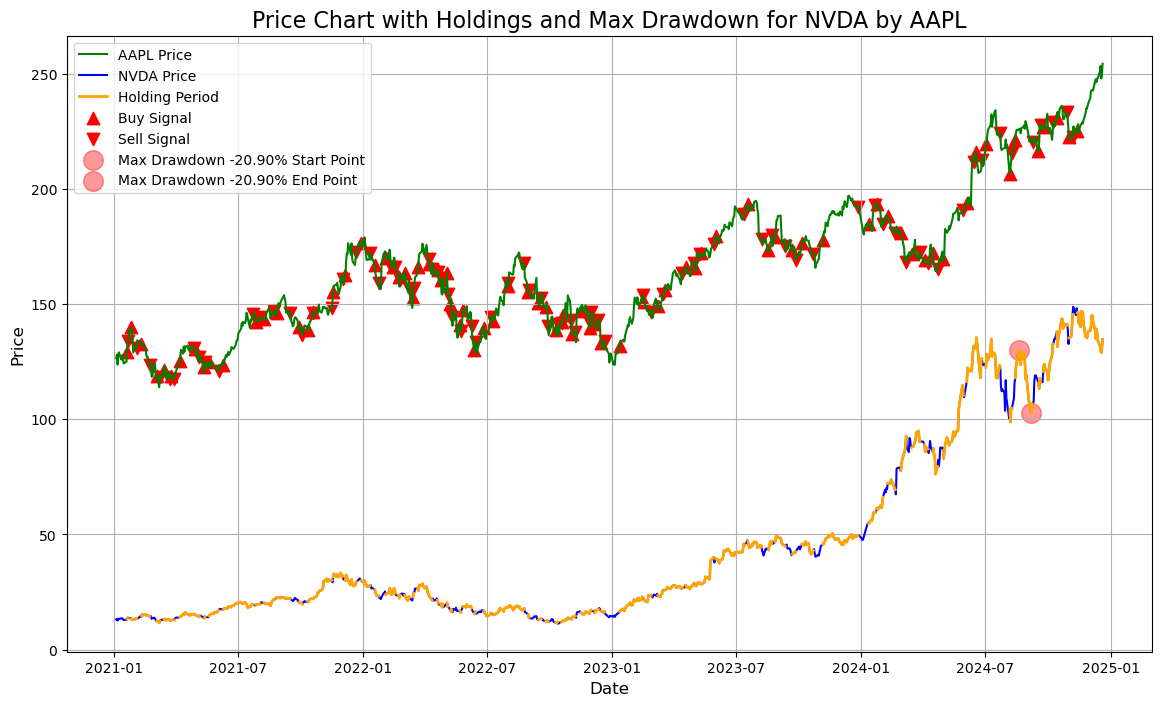

In [42]:
plot_price_with_holdings(large_cap_data['Adj Close'], stat['trades'], large_cap_pairs[0]['X'], large_cap_pairs[0]['Y'], stat['max_drawdown_record'])

In [ ]:
def calculate_alpha_beta(strategy_returns, benchmark_returns, risk_free_rate=0.045):
    # Ensure inputs are numpy arrays
    strategy_returns = np.array(strategy_returns)
    benchmark_returns = np.array(benchmark_returns)
    
    # Ensure both arrays have the same length
    if len(strategy_returns) != len(benchmark_returns):
        raise ValueError("Strategy returns and benchmark returns must be of equal length.")
    
    # Perform linear regression
    beta, alpha, _, _, _ = stats.linregress(benchmark_returns, strategy_returns)
    
    # Adjust alpha for the risk-free rate
    alpha_adjusted = alpha - risk_free_rate * (1 - beta)
    
    # Return the results as a dictionary
    return {
        "Beta": round(beta, 2),
        "Alpha (Adjusted)": round(alpha_adjusted, 2)
    }

## 4.5 Grid_search to find best model based on training set

In [44]:
def train_parameters(pair, df_vol, df_price, df_rf, initial_capital=100000, transaction=0):
    """
    Train window, k1, k2 parameters on the training set.

    Parameters:
        pair (dict): A dictionary containing the Granger causality pair with keys 'X', 'Y', and 'lag'.
        df_vol (pd.DataFrame): DataFrame with the volatility time series data.
        df_price (pd.DataFrame): DataFrame with the price time series data.
        df_rf (pd.DataFrame): DataFrame with the risk-free rate time series data.
        initial_capital (float): Starting capital for the strategy.

    Returns:
        dict: Best parameters (window, k1, k2) and strategy performance on the training set.
    """
    best_params = None
    best_stat = None
    best_sr = -np.inf

    # Grid search for parameters
    years = df_vol.index.year.unique()

    for window in range(1, 11):  # Example range for window
        for k1 in np.linspace(1.0, 1.5, 11):
            for k2 in np.linspace(0.5, 1.0, 11):
                sharpe_ratios = []

                for year in years[:-1]:  # Exclude the last year for validation
                    yearly_vol = df_vol[df_vol.index.year == year]
                    yearly_price = df_price[df_price.index.year == year]
                    yearly_rf = df_rf[df_rf.index.year == year]

                    result = moving_average_strategy(pair, yearly_vol, yearly_price, yearly_rf, window, k1, k2, initial_capital, transaction)
                    sharpe_ratios.append(result['sharpe_ratio'])

                avg_sharpe_ratio = np.mean(sharpe_ratios)

                if avg_sharpe_ratio > best_sr:
                    best_sr = avg_sharpe_ratio
                    best_params = {'window': window, 'k1': k1, 'k2': k2}

    return best_sr, best_params

## 4.6 Apply trained best model on testing set

In [45]:
def train_test(pairs, df_vol, df_price, df_rf, initial_capital=100000, transaction=0):
    
    df = pd.DataFrame()
    
    for i in tqdm(range(len(pairs)), desc="Processing Pairs"):
        best_sr, best_params = train_parameters(pairs[i], df_vol, df_price['Adj Close'], df_rf, initial_capital, transaction)
        best_window, best_k1, best_k2 = best_params['window'], best_params['k1'], best_params['k2']
        best_stat = moving_average_strategy(pairs[i], df_vol.loc['2024'], df_price.loc['2024']['Adj Close'], df_rf, best_window, best_k1, best_k2, initial_capital, transaction)
        
        local = pd.DataFrame({
            'X': [pairs[i]['X']],
            'Y': [pairs[i]['Y']],
            'lag': [pairs[i]['lag']],
            'training sharpe ratio': [best_sr],
            'best_window': [best_window],
            'best_k1': [best_k1],
            'best_k2': [best_k2],
            'test_return': [best_stat['return']], 
            'test_benchmark_return': [best_stat['benchmark_return']],
            'test_mdd': [best_stat['max_drawdown_record'][0]], 
            'test_mdd_start_date': [best_stat['max_drawdown_record'][1]],
            'test_mdd_end_date': [best_stat['max_drawdown_record'][2]],
            'test_sharpe_ratio': [best_stat['sharpe_ratio']],
            'test_trades':[best_stat['trades']]
        })
        df = pd.concat([df, local], axis=0, ignore_index=True)
    
    return df

### 4.6.1 Large Cap + No Transaction Cost (LCNT)

In [46]:
lcnt = train_test(pairs=large_cap_pairs, df_vol=large_cap_vol, df_price=large_cap_data, df_rf=df_rf, initial_capital=100000, transaction=0)
lcnt

Processing Pairs: 100%|█████████████████████████| 20/20 [03:23<00:00, 10.18s/it]


,X,Y,lag,training sharpe ratio,best_window,best_k1,best_k2,test_return,test_benchmark_return,test_mdd,test_mdd_start_date,test_mdd_end_date,test_sharpe_ratio,test_trades
0,AAPL,NVDA,4,4.215346,2,1.05,1.00,-0.015681,1.797255,-0.066455,2024-06-18,2024-06-21,-1.547789,"[{'action': 'buy', 'price': 88.72601318359375,..."
1,AAPL,MSFT,3,2.076544,9,1.00,1.00,0.145397,0.186035,-0.065125,2024-07-05,2024-07-19,1.357805,"[{'action': 'buy', 'price': 395.939208984375, ..."
2,AAPL,AMZN,2,0.356703,7,1.00,0.95,0.452674,0.500167,-0.194900,2024-07-02,2024-08-05,1.420029,"[{'action': 'buy', 'price': 153.16000366210938..."
3,AAPL,META,2,0.853360,4,1.00,0.95,0.638967,0.696513,-0.184264,2024-04-05,2024-04-30,1.502400,"[{'action': 'buy', 'price': 369.06024169921875..."
4,AAPL,BRK-B,2,0.872272,9,1.00,0.95,0.213171,0.250345,-0.075809,2024-09-04,2024-11-04,1.236728,"[{'action': 'buy', 'price': 368.05999755859375..."
5,AAPL,V,1,1.018448,10,1.05,1.00,0.016913,0.234330,-0.026549,2024-07-17,2024-07-19,0.791960,"[{'action': 'buy', 'price': 271.62164306640625..."
6,NVDA,AMZN,2,3.856733,3,1.10,1.00,0.005766,0.500167,-0.016061,2024-05-30,2024-05-31,0.796098,"[{'action': 'buy', 'price': 174.72999572753906..."
7,NVDA,META,1,4.747025,1,1.15,0.95,-0.000909,0.696513,-0.055839,2024-03-07,2024-03-11,-0.032537,"[{'action': 'buy', 'price': 482.6996765136719,..."
8,MSFT,TSLA,5,1.458984,1,1.05,1.00,0.000000,0.694952,0.000000,NaT,NaT,0.000000,[]
9,MSFT,BRK-B,2,3.164542,4,1.05,1.00,0.000000,0.250345,0.000000,NaT,NaT,0.000000,[]


In [100]:
lcnt['test_sharpe_ratio'].mean()

5.425716407748768

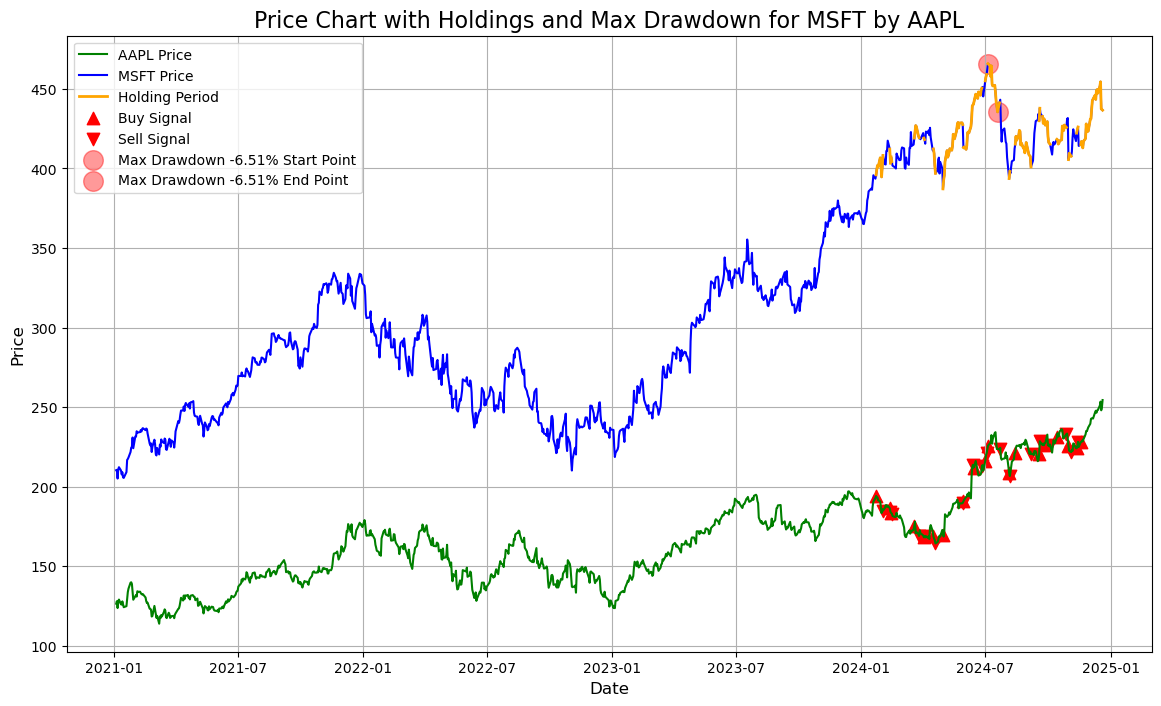

In [77]:
num1 = 1
plot_price_with_holdings(large_cap_data['Adj Close'], lcnt.iloc[num1]['test_trades'], lcnt.iloc[num1]['X'], lcnt.iloc[num1]['Y'], (lcnt.iloc[num1]['test_mdd'],lcnt.iloc[num1]['test_mdd_start_date'],lcnt.iloc[num1]['test_mdd_end_date']))

### 4.6.2 Large Cap + Transaction Cost (5bp) (LCT)

In [51]:
lct = train_test(pairs=large_cap_pairs, df_vol=large_cap_vol, df_price=large_cap_data, df_rf=df_rf, initial_capital=100000, transaction=0.0005)
lct

Processing Pairs: 100%|█████████████████████████| 20/20 [03:24<00:00, 10.25s/it]


,X,Y,lag,training sharpe ratio,best_window,best_k1,best_k2,test_return,test_benchmark_return,test_mdd,test_mdd_start_date,test_mdd_end_date,test_sharpe_ratio,test_trades
0,AAPL,NVDA,4,4.097344,2,1.05,1.00,-0.017648,1.797255,-0.066455,2024-06-18,2024-06-21,-1.764918,"[{'action': 'buy', 'price': 88.72601318359375,..."
1,AAPL,MSFT,3,1.921809,9,1.00,1.00,0.123834,0.186035,-0.065125,2024-07-05,2024-07-19,1.144143,"[{'action': 'buy', 'price': 395.939208984375, ..."
2,AAPL,AMZN,2,0.340132,7,1.00,0.95,0.449770,0.500167,-0.194900,2024-07-02,2024-08-05,1.412238,"[{'action': 'buy', 'price': 153.16000366210938..."
3,AAPL,META,2,0.843903,4,1.00,0.95,0.635692,0.696513,-0.184264,2024-04-05,2024-04-30,1.496540,"[{'action': 'buy', 'price': 369.06024169921875..."
4,AAPL,BRK-B,2,0.830558,9,1.00,0.50,0.230090,0.250345,-0.075809,2024-09-04,2024-11-04,1.309758,"[{'action': 'buy', 'price': 368.05999755859375..."
5,AAPL,V,1,0.907693,10,1.05,1.00,0.013866,0.234330,-0.026549,2024-07-17,2024-07-19,0.599121,"[{'action': 'buy', 'price': 271.62164306640625..."
6,NVDA,AMZN,2,3.629501,3,1.10,1.00,0.002752,0.500167,-0.016061,2024-05-30,2024-05-31,0.308412,"[{'action': 'buy', 'price': 174.72999572753906..."
7,NVDA,META,1,4.652582,1,1.15,0.95,-0.001908,0.696513,-0.055839,2024-03-07,2024-03-11,-0.099438,"[{'action': 'buy', 'price': 482.6996765136719,..."
8,MSFT,TSLA,5,1.267829,1,1.05,1.00,0.000000,0.694952,0.000000,NaT,NaT,0.000000,[]
9,MSFT,BRK-B,2,2.695989,4,1.05,1.00,0.000000,0.250345,0.000000,NaT,NaT,0.000000,[]


In [111]:
lct['test_sharpe_ratio'].mean()

5.037830100971773

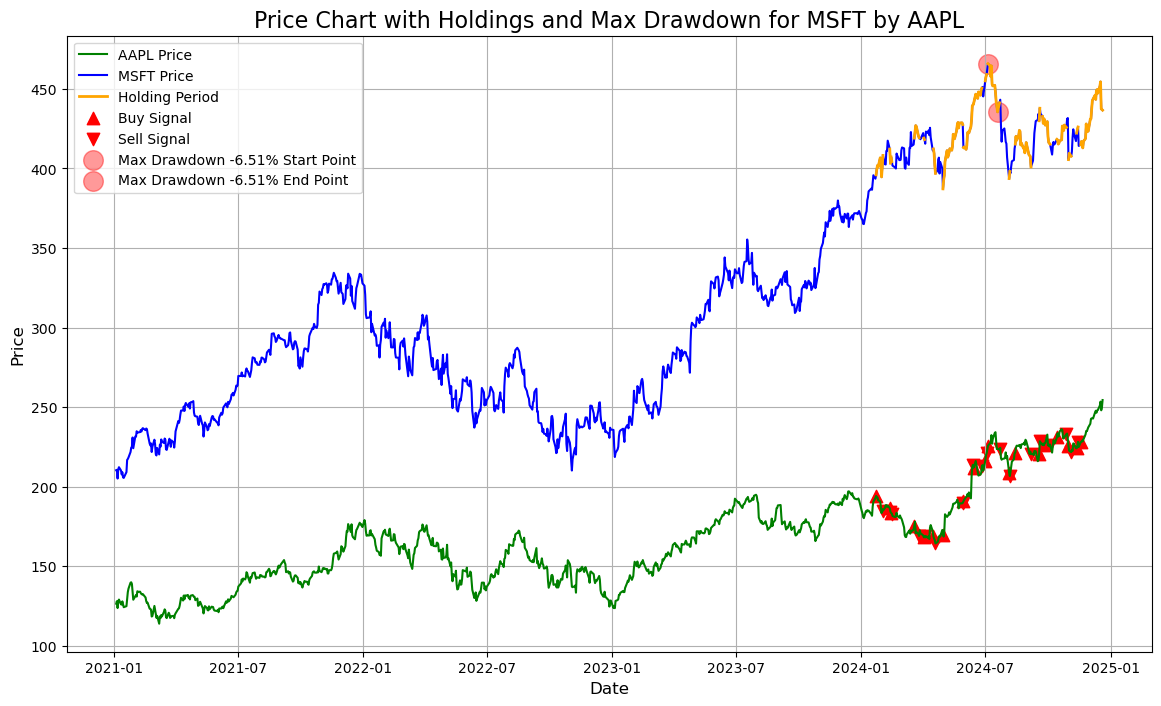

In [78]:
plot_price_with_holdings(large_cap_data['Adj Close'], lct.iloc[num1]['test_trades'], lct.iloc[num1]['X'], lct.iloc[num1]['Y'], (lct.iloc[num1]['test_mdd'],lct.iloc[num1]['test_mdd_start_date'],lct.iloc[num1]['test_mdd_end_date']))

### 4.6.3 Small Cap + No Transaction Cost (SCNT)

In [89]:
scnt = train_test(pairs=small_cap_pairs, df_vol=small_cap_vol, df_price=small_cap_data, df_rf=df_rf, initial_capital=100000, transaction=0)
scnt

Processing Pairs: 100%|█████████████████████████| 12/12 [01:57<00:00,  9.81s/it]


,X,Y,lag,training sharpe ratio,best_window,best_k1,best_k2,test_return,test_benchmark_return,test_mdd,test_mdd_start_date,test_mdd_end_date,test_sharpe_ratio,test_trades
0,HEI,TTC,1,36.838819,2,1.05,1.0,0.000000,-0.125233,0.000000,NaT,NaT,0.000000,[]
1,HEI,BCPC,1,11.119626,3,1.05,1.0,0.000000,0.131943,0.000000,NaT,NaT,0.000000,[]
2,FDS,TECH,5,1.636026,2,1.05,1.0,0.000000,-0.042033,0.000000,NaT,NaT,0.000000,[]
3,FDS,TTC,1,1.428179,8,1.05,1.0,-0.008947,-0.125233,-0.028962,2024-07-17,2024-07-22,-2.111989,"[{'action': 'buy', 'price': 99.02686309814453,..."
4,IEX,TTC,3,2.707949,10,1.05,1.0,-0.019782,-0.125233,-0.089750,2024-02-12,2024-03-07,-0.381949,"[{'action': 'buy', 'price': 90.97079467773438,..."
5,IEX,CHE,2,2.475130,5,1.05,1.0,0.057516,-0.103015,-0.012507,2024-11-01,2024-11-04,7.765261,"[{'action': 'buy', 'price': 531.6799926757812,..."
6,IEX,BCPC,4,2.753404,10,1.05,1.0,0.167899,0.131943,-0.036966,2024-11-06,2024-11-07,2.803215,"[{'action': 'buy', 'price': 142.27999877929688..."
7,TECH,CHE,5,3.071660,1,1.05,1.0,0.000123,-0.103015,-0.011213,2024-05-10,2024-05-13,-0.362410,"[{'action': 'buy', 'price': 571.79296875, 'sha..."
8,TECH,MSA,5,2.125023,1,1.05,1.0,0.010280,-0.007153,-0.014368,2024-09-26,2024-09-27,1.710975,"[{'action': 'buy', 'price': 186.55096435546875..."
9,TECH,BCPC,4,7.863463,1,1.05,1.0,0.048491,0.131943,-0.014150,2024-05-07,2024-05-08,5.414328,"[{'action': 'buy', 'price': 155.47999572753906..."


In [102]:
scnt['test_sharpe_ratio'].mean()

1.3488575033319206

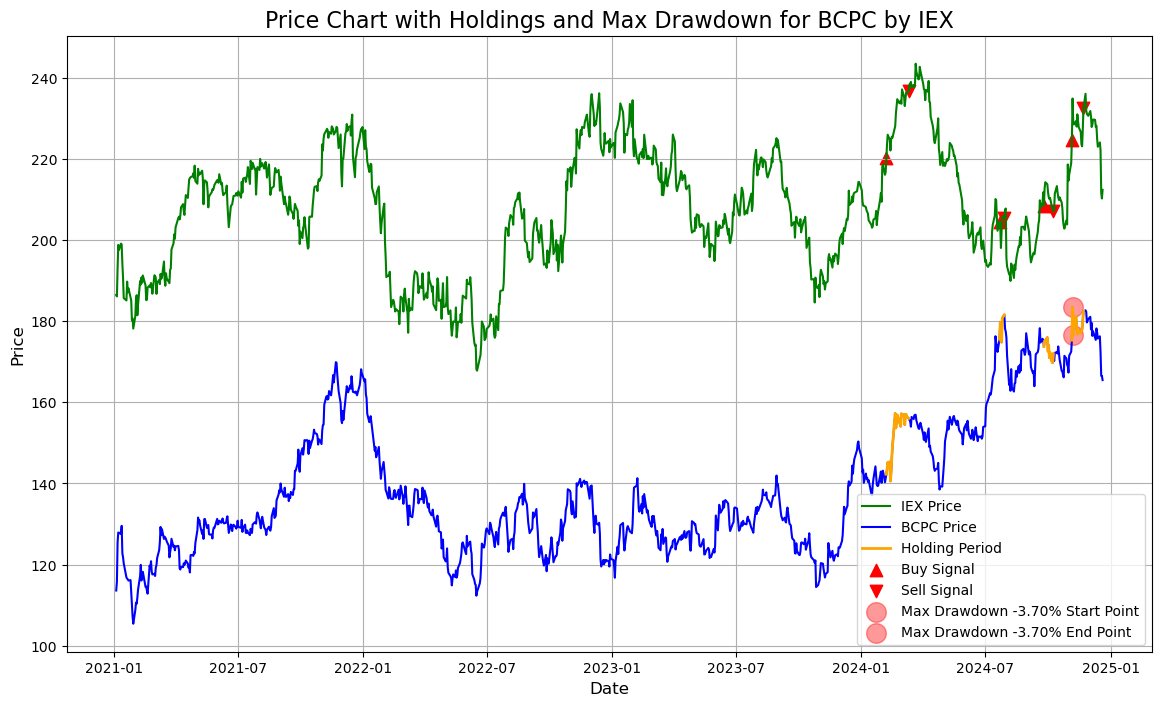

In [95]:
num2 = 6
plot_price_with_holdings(small_cap_data['Adj Close'], scnt.iloc[num2]['test_trades'], scnt.iloc[num2]['X'], scnt.iloc[num2]['Y'], (scnt.iloc[num2]['test_mdd'],scnt.iloc[num2]['test_mdd_start_date'],scnt.iloc[num2]['test_mdd_end_date']))

### 4.6.4 Small Cap + Transaction Cost (15bp) (SCT) 

In [96]:
sct = train_test(pairs=small_cap_pairs, df_vol=small_cap_vol, df_price=small_cap_data, df_rf=df_rf, initial_capital=100000, transaction=0.0015)
sct

Processing Pairs: 100%|█████████████████████████| 12/12 [01:57<00:00,  9.77s/it]


,X,Y,lag,training sharpe ratio,best_window,best_k1,best_k2,test_return,test_benchmark_return,test_mdd,test_mdd_start_date,test_mdd_end_date,test_sharpe_ratio,test_trades
0,HEI,TTC,1,33.125224,2,1.05,1.00,0.000000,-0.125233,0.000000,NaT,NaT,0.000000,[]
1,HEI,BCPC,1,7.752266,3,1.05,1.00,0.000000,0.131943,0.000000,NaT,NaT,0.000000,[]
2,FDS,TECH,5,0.854161,6,1.05,1.00,0.038699,-0.042033,-0.031277,2024-09-30,2024-10-02,5.310358,"[{'action': 'buy', 'price': 76.34785461425781,..."
3,FDS,TTC,1,1.072903,8,1.05,1.00,-0.014880,-0.125233,-0.028962,2024-07-17,2024-07-22,-3.321322,"[{'action': 'buy', 'price': 99.02686309814453,..."
4,IEX,TTC,3,2.407915,10,1.05,1.00,-0.031484,-0.125233,-0.089750,2024-02-12,2024-03-07,-0.605595,"[{'action': 'buy', 'price': 90.97079467773438,..."
5,IEX,CHE,2,2.270410,5,1.05,1.00,0.054346,-0.103015,-0.012507,2024-11-01,2024-11-04,7.086163,"[{'action': 'buy', 'price': 531.6799926757812,..."
6,IEX,BCPC,4,2.366332,10,1.05,1.00,0.153958,0.131943,-0.036966,2024-11-06,2024-11-07,2.606571,"[{'action': 'buy', 'price': 142.27999877929688..."
7,TECH,CHE,5,0.717309,10,1.05,1.00,0.004844,-0.103015,-0.089170,2024-12-04,2024-12-18,-0.016332,"[{'action': 'buy', 'price': 596.8726806640625,..."
8,TECH,MSA,5,1.315040,8,1.10,0.95,-0.070433,-0.007153,-0.092031,2024-05-15,2024-06-06,-5.193258,"[{'action': 'buy', 'price': 186.55096435546875..."
9,TECH,BCPC,4,4.967515,1,1.05,1.00,0.035975,0.131943,-0.014150,2024-05-07,2024-05-08,4.136422,"[{'action': 'buy', 'price': 155.47999572753906..."


In [103]:
sct['test_sharpe_ratio'].mean()

0.9093641565757644

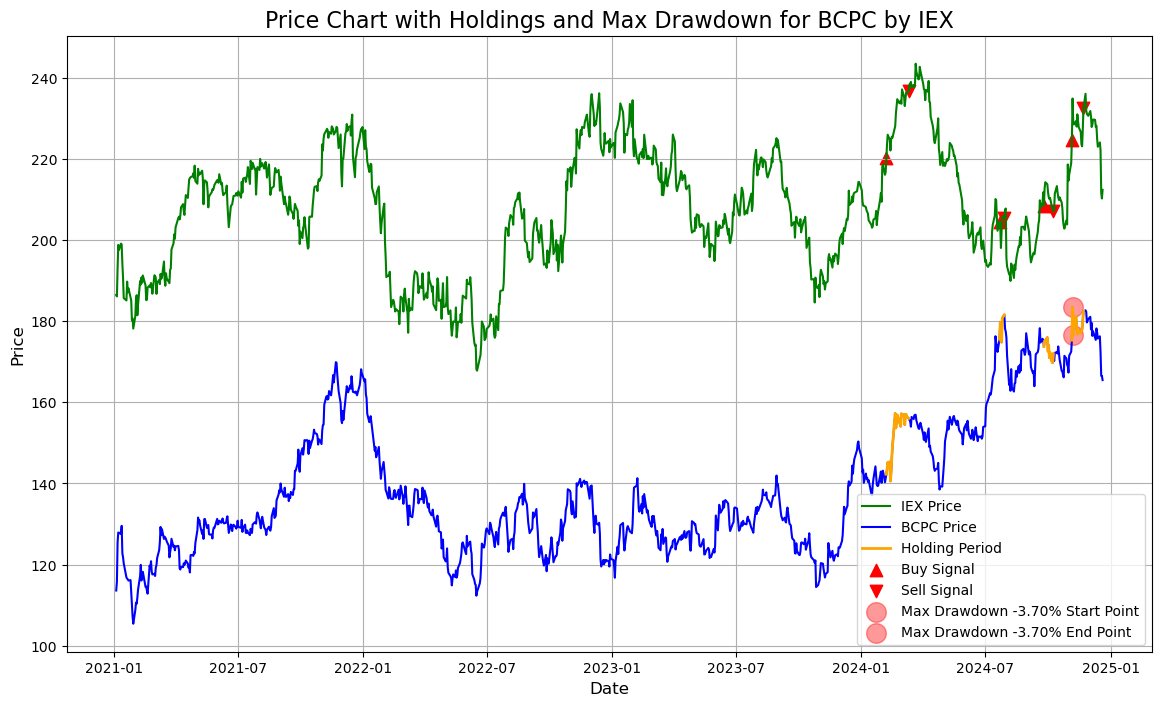

In [97]:
plot_price_with_holdings(small_cap_data['Adj Close'], sct.iloc[num2]['test_trades'], sct.iloc[num2]['X'], sct.iloc[num2]['Y'], (sct.iloc[num2]['test_mdd'],sct.iloc[num2]['test_mdd_start_date'],sct.iloc[num2]['test_mdd_end_date']))

# 5. Conclusions

## 5.1 Sharpe Ratios

- Large-cap stocks without transaction costs: SR = 5.43, great
- Large-cap stocks with transaction costs: SR = 5.04, great
- Small-cap stocks without transaction costs: SR = 1.35, mediocre
- Small-cap stocks with transaction costs: SR = 0.91, bad

Both with and without transaction costs, **Large-cap stocks** consistently exhibited **higher mean Sharpe ratios (>5)** compared to small-cap stocks, reflecting their relative stability and lower sensitivity to market volatility.

For **Small-cap stocks**, even the **benchmark strategy** (buy-and-hold) performed **poorly**, as their volatile nature makes long-term holding less effective. The result of our strategy showed significantly **lower mean Sharpe ratios (~1)** than Large-cap stock , emphasizing the challenges in achieving consistent performance due to their high price volatility.

## 5.2 Impact of Transaction Costs

- **For large-cap stocks**:
  - The presence or absence of transaction costs had **minimal impact on the choice of optimal parameters** for the strategy.
  - Parameter optimization is less affected by cost considerations, allowing for more consistent performance across different cost scenarios.
  - Transaction costs primarily affected the **overall performance** of the strategy, reducing the Sharpe ratio but not altering the fundamental parameter selections.

- **For small-cap stocks**:
  - Transaction costs had a **significant impact on the choice of optimal parameters**, requiring careful calibration to maintain profitability. Strategies needed to be adjusted to account for higher sensitivity to transaction costs.
  - The **test Sharpe ratio** was also strongly influenced by transaction costs, indicating that strategies for small-cap stocks must carefully consider these costs to remain profitable.

In [1]:
(5.43+1.35)/2

3.3899999999999997

# <center>End
# <center>Thank you